# 00 - C++ A compiled language in jupyter-lab

Contrary to python c++ is a compiled language. We first need to write the code. Then compile it to a executable which can be run. 

We can use Jupyter-labs cell-magic to still work usefully in this work. 

With a cell starting with ```%%writefile fileName```we can write a file to the local storage. 

In [ ]:
%%writefile helloWorld.cpp

#include <iostream>

int main() 

{
    std::cout << "Hello world. I pretend to be interactive." << std::endl;

    return 0;

}

With lines started with ```!``` are interpreted as bash commands. We can use this to compile the main.cpp to a executable with gcc by the following command. 

In [ ]:
! g++ helloWorld.cpp -o helloWorld

We can now try to execute the program again as bash command ```!```

In [ ]:
! ./helloWorld

# 00 - installing PyTorch 

If you want to run PyTorch in c++ you first need to install it. The same holds on the Google Colab servers.
We can again use the bash commands to get it. You can download it from https://pytorch.org/get-started/locally/ . 
For Linux you will find 2 possible downloads (besides building from source.) With c++11 the string api changed which requires 
different versions of the code. Make sure to download the appropriat one for your dependencies. In doubt use the one with the new syntax for c++11 or higher. 


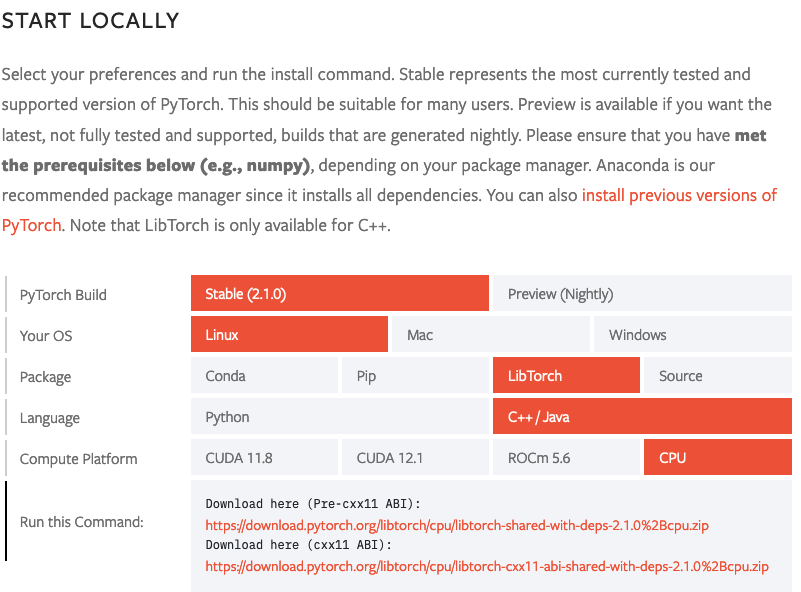


We can directly download the ziped file with wget (bash-command)
We can unpack the precomiled library with ```unzip``` this will create the libTorch folder with the needed pacakge. 

In [ ]:
## Post c++11

#! wget https://download.pytorch.org/libtorch/cpu/libtorch-cxx11-abi-shared-with-deps-2.1.0%2Bcpu.zip
#! unzip libtorch-cxx11-abi-shared-with-deps-2.1.0+cpu.zip

In [ ]:
## Pre c++11 API

! wget https://download.pytorch.org/libtorch/cpu/libtorch-shared-with-deps-2.1.0%2Bcpu.zip
! unzip libtorch-shared-with-deps-2.1.0+cpu.zip

# 01- Compiling against PyTorch 

In [ ]:
%%writefile main.cpp


#include <torch/torch.h>

#include <iostream>

int main() 

{

    torch::Tensor tensor = torch::rand({2, 3});

    std::cout << "Test" << std::endl;
    
    return 0;

}

In [ ]:
! g++ main.cpp -o main

We need to tell the compiler where to find torch. As it is very hard to manage all dependencies of large programms such as cfd codes cmake can be used to manage dependencies. 
To use it we need to write a CMakeLists.txt.

In [ ]:
%%writefile CMakeLists.txt

cmake_minimum_required(VERSION 3.0 FATAL_ERROR)
project(pytorch-app)

# Export compile commands
set(CMAKE_EXPORT_COMPILE_COMMANDS ON)
# Enable find_package search with <package_name>_ROOT suffix
cmake_policy(SET CMP0074 NEW)

find_package(Torch REQUIRED)
set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} ${TORCH_CXX_FLAGS}")

set(MY_EXE hello-PyTorch.x)

add_executable(${MY_EXE} main.cpp)
target_link_libraries(${MY_EXE} "${TORCH_LIBRARIES}") # here we tell cmake that we need the pytorch library. 
set_property(TARGET ${MY_EXE} PROPERTY CXX_STANDARD 17)

add_test(NAME ${MY_EXE}
        COMMAND ${MY_EXE}
        WORKING_DIRECTORY ${PROJECT_SOURCE_DIR}
        )

Still Cmake will not find the local copy of libtorch. We have just put it in a random spot. On your own machine or a cluster you can work with enviroment variables. In case of libtorch we would need to point to the libtorch location in the Env-variable Torch_DIR. We can set it by the bash command ``` export Torch_DIR="/content/libtorch/share/cmake/Torch"  ```. However when working in google colab we can't set enviroment variables. 

Sadly we can't set enviroment variables in colab. Instead we will set the variables when evoking cmake as flag: ```-DTorch_DIR="../libtorch/share/cmake/Torch"``` The path should point to the ```TorchConfig.cmake```.

In [ ]:
! cmake  . -DTorch_DIR="libtorch/share/cmake/Torch"

This should have created a new folder ```CMakeFiles ``` and some auxiliary files. These contain all the paths and dependencies which need to be set. We can now build the programm with make

In [ ]:
! make 

In [ ]:
! ./hello-PyTorch.x

# 02 - Creating a Model 

Now we will create a model in python, jit compile it and use it a c++ programm.
Here we will generate a model in python.

In [ ]:
import torch
import torch.nn as nn
import argparse
from typing import List

In [ ]:
class FlexMLP(torch.nn.Module):
    def __init__(self, n_inp: int, n_out: int, n_hidden_neurons: List[int] =[32, 32], activation_fn: torch.nn.Module = nn.ReLU):
         super().__init__()

         self.n_inp = n_inp
         self.n_out = n_out
         self.n_neurons = [n_inp] + n_hidden_neurons + [n_out]
         self.hidden_layers = len(n_hidden_neurons)
         self.layers = torch.nn.ModuleList()
         self.activation = activation_fn

         # construct the network
         # -2 because we add the last layer manually to avoid an activatin there
         for i in range(len(self.n_neurons)-2):
             self.layers.append(torch.nn.Linear(self.n_neurons[i], self.n_neurons[i+1]))
             self.layers.append(self.activation())
         self.layers.append(nn.Linear(self.n_neurons[-2], self.n_neurons[-1]))

    def forward(self, x):
         # loop through all layer but last
         for layer in self.layers:
             x = layer(x)
         return x

In [ ]:

n_inp = 2 #args.ninp
n_out = 1 #args.nout
n_neurons = [10, 10, 10]

m = FlexMLP(n_inp, n_out, n_neurons).double()
s = torch.jit.script(m)
s.save("model.pt")


## Running the compiled model

In [ ]:
%%writefile main.cpp

#include <torch/script.h>

#include <iostream>
#include <memory>

int main(int argc, const char* argv[]) 
{
    if (argc != 2) {
        std::cerr << "usage: run_torch.x <path-to-exported-script-module>\n";
        return -1;
    }

    // 1) Load the model
    torch::jit::script::Module module;
    try {
        // Deserialize the ScriptModule from a file using torch::jit::load().
        module = torch::jit::load(argv[1]);
    }
    catch (const c10::Error& e) {
        std::cerr << "error loading the model\n";
        return -1;
    }
    
    // 2) Create input data with factory functions for torch::Tensor
    auto options = torch::TensorOptions().dtype(torch::kDouble);
    auto input_tensor = torch::rand({10, 2}, options);

    // Input must be of type std::vector<IValue>
    std::vector<torch::jit::IValue> inputs;
    inputs.push_back(input_tensor);

    // 3) Forward pass
    auto output = module.forward(inputs).toTensor();

    // 4) Print output
    std::cout << output << std::endl;

    // 5) Exercises
    // 5.1) Only print rows 5-7 of the output tensor
    //      Hint: Look at the tensor.slice method
    std::cout << output << std::endl;
    
    // 5.2) Only print column 1 of the output tensor
    std::cout << output << std::endl;

    // 5.3) What is the data layout of rows and columns of the torch tensor? 
    //      Can you use std::copy to copy a row into a std::vector? Or a column?
    //      Hint: output.data_ptr<double>() gives you a raw pointer to the underlying data array


    // 5.4) Create a tensor from a std::vector using the torch::from_blob fractory-method
    
    return 0;
}


In [ ]:
%%writefile CMakeLists.txt

cmake_minimum_required(VERSION 3.0 FATAL_ERROR)
project(pytorch-app)

# Export compile commands
set(CMAKE_EXPORT_COMPILE_COMMANDS ON)
# Enable find_package search with <package_name>_ROOT suffix
cmake_policy(SET CMP0074 NEW)

find_package(Torch REQUIRED)
set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} ${TORCH_CXX_FLAGS}")

set(MY_EXE load-torch-model.x)

add_executable(${MY_EXE} main.cpp)
target_link_libraries(${MY_EXE} "${TORCH_LIBRARIES}") # here we tell cmake that we need the pytorch library. 
set_property(TARGET ${MY_EXE} PROPERTY CXX_STANDARD 17)

add_test(NAME ${MY_EXE}
        COMMAND ${MY_EXE}
        WORKING_DIRECTORY ${PROJECT_SOURCE_DIR}
        )

In [ ]:
! cmake  . -DTorch_DIR="libtorch/share/cmake/Torch"
! make 

In [ ]:
! ./load-torch-model.x model.pt

# 03 - Train DNN

Now we will train an NN to reproduce a polynomial. Instead of Python we will utilize the c++ API.

In [ ]:
%%writefile main.cpp

// Copyright 2020-present pytorch-cpp Authors
// This file has been taken from https://github.com/prabhuomkar/pytorch-cpp/blob/master/tutorials/basics/linear_regression/main.cpp
// Small modification: Train a polynomial instead of a linear regression 
#include <torch/torch.h>
#include <iostream>
#include <iomanip>

auto polynomial(torch::Tensor x)
{
    return 1.5*torch::pow(x, 2) + 2*x - 3;
}

int main() {
    std::cout << "Linear Regression\n\n";
    std::cout << "Training on CPU.\n";

    // Hyper parameters
    const int64_t input_size = 1;
    const int64_t output_size = 1;
    const std::vector<int64_t> hiddenLayers = {16, 16};
    const size_t num_epochs = 60;
    const double learning_rate = 0.01;

    // Sample dataset
    const int64_t nums = 101;
    auto x_train = torch::linspace(-5, 5, nums).unsqueeze(1);
    auto y_train = polynomial(x_train);

    std::cout << x_train << std::endl;

    // This snippet has been taken from https://github.com/OFDataCommittee/OFMLHackathon/blob/main/2022-07/physics-based-dl/applications/pinnFoam/pinnFoam.C
    // Construct the MLP
    torch::nn::Sequential model;
    model->push_back(torch::nn::Linear(input_size, hiddenLayers[0]));
    model->push_back(torch::nn::GELU()); // FIXME: RTS activation function.
    // - Hidden layers
    for (int64_t L=1; L < hiddenLayers.size(); ++L)
    {
        model->push_back(
            torch::nn::Linear(hiddenLayers[L-1], hiddenLayers[L])
        );
        // TODO: RTS Alternatives TM.
        model->push_back(torch::nn::GELU());
        //model->push_back(torch::nn::Tanh());
    }
    // - Output is 1D: value of the learned scalar field.
    // TODO: generalize here for vector / scalar data.
    model->push_back(
        torch::nn::Linear(hiddenLayers[hiddenLayers.size() - 1], 1)
    );

    // Optimizer
    torch::optim::SGD optimizer(model->parameters(), torch::optim::SGDOptions(learning_rate));

    // Set floating point output precision
    std::cout << std::fixed << std::setprecision(4);

    std::cout << "Training...\n";

    // Train the model
    for (size_t epoch = 0; epoch != num_epochs; ++epoch) {
        // Forward pass
        auto output = model->forward(x_train);
        auto loss = torch::nn::functional::mse_loss(output, y_train);

        // Backward pass and optimize
        optimizer.zero_grad();
        loss.backward();
        optimizer.step();

        if ((epoch + 1) % 5 == 0) {
            std::cout << "Epoch [" << (epoch + 1) << "/" << num_epochs <<
                "], Loss: " << loss.item<double>() << "\n";
        }
    }
    std::cout << "Training finished!\n";

    // Plot validation
    std::cout << "Validation:\n";

    auto x_validation = torch::linspace(-5, 5, 11).unsqueeze(1);
    auto y_validation = polynomial(x_validation);
    //std::vector<torch::IValue> vali_inputs{};
    //vali_inputs.push_back(x_validation);
    //auto y_prediction = model->forward(vali_inputs).toTensor();
    auto y_prediction = model->forward(x_validation);

    std::cout << y_prediction << std::endl;
    std::cout << y_validation << std::endl;

    return 0;
}

In [ ]:
%%writefile CMakeLists.txt

cmake_minimum_required(VERSION 3.0 FATAL_ERROR)
project(pytorch-app)

# Export compile commands
set(CMAKE_EXPORT_COMPILE_COMMANDS ON)

# Enable find_package search with <package_name>_ROOT suffix
cmake_policy(SET CMP0074 NEW)

find_package(Torch REQUIRED)
set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} ${TORCH_CXX_FLAGS}")

set(MY_EXE train-DNN.x)

add_executable(${MY_EXE} main.cpp)
target_link_libraries(${MY_EXE} "${TORCH_LIBRARIES}")
set_property(TARGET ${MY_EXE} PROPERTY CXX_STANDARD 17)

add_test(NAME ${MY_EXE}
        COMMAND ${MY_EXE}
        WORKING_DIRECTORY ${PROJECT_SOURCE_DIR}
        )


In [ ]:
! cmake  . -DTorch_DIR="libtorch/share/cmake/Torch"
! make 

In [ ]:
! ./train-DNN.x

# Excersise 

Adjust the following hyperparameter that the neural network adequately approximates the given polynomial function?

- Learning rate
- Hidden layer neurons (number and size)
- Activation function